In [2]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
%matplotlib inline

In [3]:
global verbose
verbose = False

In [4]:
def read_cards_file():
    with open("cards.txt") as f:
        try:
            cards = f.read().split('\n')[0:-1]
        except:
            for value in range(2, 11):
                for suit in ['c', 's', 'd', 'h']:
                    f.write(f'{value}{suit}\n')
            for value in ['J', 'Q', 'K', 'A']:
                for suit in ['c', 's', 'd', 'h']:
                    f.write(f'{value}{suit}\n')
            cards = f.read().split('\n')
            cards = cards[0:-1]
    return cards

In [5]:
cards_list = read_cards_file()

In [34]:
class Card:
    
    '''Object with useful fields for playing card games
    
    Attributes:
        name (str): Combination of pip and suit for human readability.
        suit (str): One of four traditional suits of standard decks. Uses single letter abbreviations.
        pip (str): The number or face of a card. Face cards deafult to single letter abbreviations.
        value (int): Integer representations of the pip for better comparisons. Ace defaults to 1.
        turns_held (int): WIP. Keeps track of how long the current player has held it.
    
    Notes:
        Face card abbreviations: J, Q, K, and A
        Suit abbreviations: C, S, H, and D
        
        For value, ace deafualts to 1.
    
    TODO:
        Get the turns_held attribute implemented.
        Add option to allow ace to default to 14.
        
    '''
    
    def __init__(self, pip=None, suit=None, name=None):
        
        '''Takes either pip and suit args, or name arg.
        
        Note:
            Currently requires face card pips to already be abbreviated.
            Currently requires suits to already be abbreviated
        
        Args:
            pip (str): Number of number card or first letter abbreviation for face card.
            suit (str): Single letter abbreviation for suit.
            name (str): Premade combination of pip and suit. Allows for easier instancing.
        '''
        
        self._turns_held = 0
        '''int: number of turns held by current player'''
        
        if pip:
            self._pip = pip
            self._suit = suit
            self._name = f'{pip}{suit}'
        elif name:
            self._name = name
            self._pip = name[0:-1]
            self._suit = name[-1:]
            
        try:
            self._value = int(self.pip)
        except:
            if self._pip=='J':
                self._value = 11
            elif self._pip=='Q':
                self._value = 12
            elif self._pip=='K':
                self._value = 13
            elif self._pip=='A':
                self._value = 1
    
    def __str__(self):
        return f'Card {self.name}'
    
    def __repr__(self):
        return f'cards.Card({self.name})'
    
    def __eq__(self, other):
        return self.value == other.value
    
    def __lt__(self, other):
        return self.value < other.value
    
    @property
    def name(self):
        return self._name
    
    @property
    def value(self):
        return self._value
    
    @property
    def pip(self):
        return self._pip

In [25]:
def get_value_dic(*args, hand=None):
    
    '''Takes list of cards and returns dic with present values and their frequencies
    
    Notes:
        Requires either a hand or *args, cannot use both
    
    Args:
        args (Card): takes any number of Card objects
        hand (list(Card)): works similarly to args, but can take premade list of Card objects
    
    Returns:
        Dictionary of present card values and their frequencies
    '''
    
# hand argument assumes list of cards
    
    card_dic = {}
    if hand:
        for card in hand:
            if card.value in card_dic:
                card_dic[card.value] +=1
            else:
                card_dic[card.value] = 1
    else:
        for card in args:
            if card.value in card_dic:
                card_dic[card.value] +=1
            else:
                card_dic[card.value] = 1
    
    return card_dic

In [26]:
def get_keys_with_max_value(cards):
    
    '''Takes cards and returns the value with the highest frequency
    
    Args:
        cards (list(Card)): list of Cards you want get information on.
    
    Returns:
        list of Card values with highest frequency. 
    '''
    
    if type(cards) == list:
        cards=get_value_dic(hand=cards)
    
    ret_keys = []
    if type(cards) == dict:
        if list(cards.values()).count(cards[max(cards, key=cards.get)]) == 1:
            ret_keys.append(max(cards, key=cards.get))
        else:
            for key in cards.keys():
                if cards[key] == cards[max(cards, key=cards.get)]:
                    ret_keys.append(key)
    return ret_keys

In [23]:
def get_key_with_min_value(cards):
    
    '''Takes cards and returns the value with the lowest frequency
    
    Args:
        cards (list(Card)): list of Cards you want get information on.
    
    Returns:
        list of Card values with lowest frequency. 
    '''
    
    if type(cards) == list:
        cards=get_value_dic(hand=cards)
    
    ret_keys = []
    if type(cards) == dict:
        if list(cards.values()).count(cards[min(cards, key=cards.get)]) == 1:
            ret_keys.append(min(cards, key=cards.get))
        else:
            for key in cards.keys():
                if cards[key] ==  cards[min(cards, key=cards.get)]:
                    ret_keys.append(key)
    return ret_keys

In [9]:
class Deck():
    
    '''Collection of 52 cards, of standard type'''
    
# Has fields
#   cards
    
    def __init__(self, empty=False):
        self.cards = deque([])
        if not empty:
            for x in cards_list:
                self.cards.append(Card(name=x))
    
    def __iter__(self):
        return iter(self.cards)
    
    def __getitem__(self, item):
        return list(self.cards)[item]
    
    def __len__(self):
        return len(self.cards)
    
    def shuffle(self):
        prev_order = self.cards
        self.cards = deque([])
        for i in range(52):
            card_index = random.randint(-1, 51-i)
            self.cards.append(prev_order[card_index])
            del prev_order[card_index]
        return self
    
    def empty(self):
        self.cards = []
    
    def get_top_card(self, remove=True):
        if remove:
            return(self.cards.popleft())
        else:
            return self.cards[0]
    
    def add(self, new_card):
        self.cards.append(new_card)
    
    def copy(self):
        new_deck = Deck(empty=True)
        for c in self.cards:
            new_deck.add(Card(name=c.name))
        return new_deck     
    

In [10]:
class Player:
    '''
    Contains methods useful for any game's players
    '''

# Has fields:
#   hand
    
    def __init__(self, dealt_cards):
        if type(dealt_cards) == list:
            self.hand = dealt_cards
        elif type(dealt_cards) == Card:
            self.hand = []
            self.hand.append(dealt_cards)
        if verbose:
            print(f'{self.hand}')
    
    def take_card(self, card):
        self.hand.append(card)
        if verbose:
            print(f'appended {card.name}')
    
    def discard_card(self, card):
        self.hand.remove(card)
        if verbose:
            print(f'removed {card.name}')
        return card
    
    def show_hand(self):
        ret_str = ''
        for card in self.hand:
            ret_str += f'{card.name} '
        return ret_str[0:len(ret_str)-1]
    

In [11]:
class SpoonsPlayer(Player):
    
    '''Implements decisions specific to game spoons'''
    
    def make_move(self, drawn_card):          
        self.take_card(drawn_card)
        uncommon_cards = get_key_with_min_value(self.hand)
        if verbose:
            print(f'uncommon cards = {uncommon_cards}')
        if len(uncommon_cards)==1:
            for card in self.hand:
                if card.value == uncommon_cards[0]:
                    return self.discard_card(card)
            print('SNGH make_move one uncommon card')
        else:          #This could be used for old card bias
            chosen_index = random.randint(0, len(uncommon_cards)-1)
            chosen_uncommon = uncommon_cards[chosen_index]
            if verbose:
                print(f'chosen index for discarded card is {chosen_index}')
                print(f'chosen discard card is {chosen_uncommon}')
            for card in self.hand:
                if card.value == chosen_uncommon:
                    return self.discard_card(card)
            print('SNGH make_move multiple uncommon card')

    def has_won(self):
        if [x.value for x in self.hand].count(self.hand[0].value) == 4:
            return True
        else:
            return False
    

## Notes:
* Current does not do true deal
* For spoons, drawn card makes its way through all players before new one is drawn

In [15]:
class Game:
    
    '''Runs single game of chosen type'''
    
# Has fields:
#   deck
#   players
#   game_type
#   finished
#   discard_pile
    
    def __init__(self, number_of_players, game_type, true_deal=False):
        self.game_type = game_type
        self.finished = False
        self.deck = Deck().shuffle()
        self.discard_pile = Deck(empty=True)
        self.players = []
        if game_type == 'spoons':
            if true_deal:
                # true deal probably wont make a difference, but i honestly dont know
                pass
            else:
                for i in range(number_of_players):
                    self.players.append(SpoonsPlayer(list(self.deck)[4*i:4*(i+1)]))
    
    def play(self):
        while True:
            for player in self.players:
                if len(self.deck) == 0:
                    self.deck=self.discard_pile.copy()
                    self.discard_pile.empty()
                if self.players.index(player) == 0:
                    active_card = player.make_move(self.deck.get_top_card())
                elif self.players.index(player) != len(self.players)-1:
                    active_card = player.make_move(active_card)
                elif self.players.index(player) == len(self.players)-1:
                    self.discard_pile.add(player.make_move(self.deck.get_top_card()))
                else:
                    print('SNGH Game.run player index not matching expected case')
                if player.has_won():
                    return self.players.index(player)
                
    
    def asd_play(self):
        turn_iterator = 0
        transitory_cards = []


In [16]:
class Simulation:

# Has fields:
#   number_of_players
#   number_of_games
#   game_type
#   results
    
    def __init__(self, number_of_players, number_of_games, game_type = 'spoons', run_on_creation=True):
        self.number_of_players = number_of_players
        self.number_of_games = number_of_games
        self.game_type = game_type
        self.results = []
        if run_on_creation:
            self.run()
    
    def run(self):
        for i in range(self.number_of_games):
            g = Game(self.number_of_players, self.game_type)
            self.results.append(g.play()+1)
    
    def show_results(self, plot_type='box'):
         try:
            if plot_type == 'box':
                res_x = []
                res_y = []
                for i in range(min(self.results), max(self.results)+1):
                    res_x.append(i)
                    res_y.append(self.results.count(i))
                plt.bar(x=res_x, height=res_y)
                plt.title('Wins by player')
                plt.xticks([1,2,3,4])
                plt.ylabel('Number of wins')
                plt.xlabel('Player number by chronological order')
         except ValueError as e:
            print('Error is: ',e)
            print('Make sure you\'ve actually run the simulation')
    

In [17]:
sim = Simulation(number_of_games=10000, number_of_players=4)

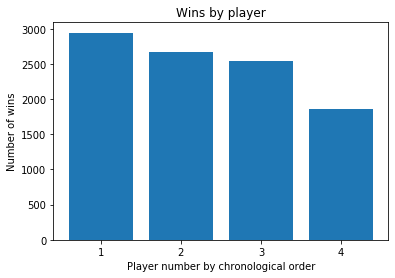

In [18]:
sim.show_results()

In [ ]:
p = SpoonsPlayer(Deck().shuffle()[0:4])